<a href="https://colab.research.google.com/github/Czedros/CSE352-Machine-Learning-Assignments/blob/main/Search/Maze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SBU CSE 352 - HW 1.2 - Search: Solving a Maze Using a Goal-based Agent


Name:  Kay Zhang

I understand that my submission needs to be my own work: yes

---

## Instructions

Total Points: 100

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Only use standard packages (numpy, scipy, and built-in packages like random). Submit the completely rendered notebook as a HTML file.


## Introduction

The agent has a map of the maze it is in and the environment is assumed to be **deterministic, discrete, and known.** The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root noteto the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible.

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [1]:
# First download the repo and change the directory to be the one where the dependencies are.
# You should only need to do this once per session. If you want to reset, do Runtime -> Disconnect and Delete Runtime
# You can always do !pwd to see the current working directory and !ls to list current files.
!git clone https://github.com/stanleybak/CS7320-AI.git
%cd CS7320-AI/Search
!ls

Cloning into 'CS7320-AI'...
remote: Enumerating objects: 2755, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 2755 (delta 4), reused 0 (delta 0), pack-reused 2740 (from 2)
Receiving objects: 100% (2755/2755), 257.09 MiB | 26.52 MiB/s, done.
Resolving deltas: 100% (1719/1719), done.
Updating files: 100% (135/135), done.
/content/CS7320-AI/Search
empty_2_maze.txt	  loops_maze.txt		     maze_helper.py   small_maze.txt
empty_maze.txt		  Maze_BFS_vs_A_Star.ipynb	     Maze.ipynb       wall_maze.txt
Explore_heuristics.ipynb  Maze_Example-Animation_full.ipynb  medium_maze.txt
large_maze.txt		  Maze_Example-Animation.ipynb	     open_maze.txt
L_maze.txt		  Maze_Example.ipynb		     README.md


In [2]:
# if the below fails to open, then small_maze.txt is not in the current working directory (see above code block)
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



__Note:__ The mazes above contains cycles and therefore the state space may not form proper trees unless cycles are prevented. Therfore, you will need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`.

In [3]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

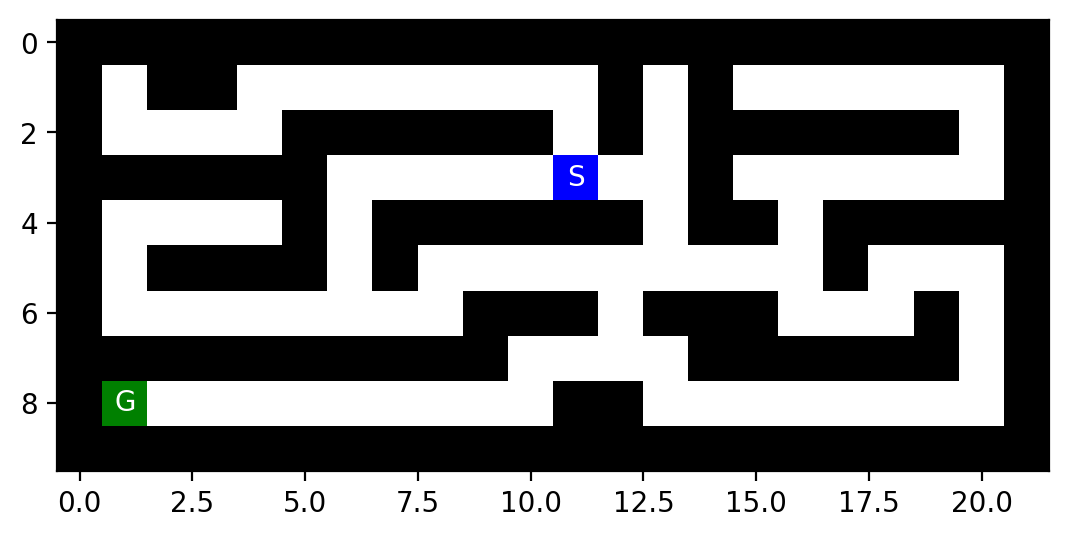

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebook

mh.show_maze(maze)

Find the position of the start and the goal using the helper function `find_pos()`

In [5]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


Helper function documentation.

In [5]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage: 
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one. 
        Caution: there is no error checking!
        
        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)
        
        Returns:
        a tupple (x, y) for the found position.
    
    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).
    
    parse_maze(maze_str)
        Convert a maze as a string into a 2d numpy array
    
    show_maze(maze, fontsize=10)
        Display a (parsed) maze as an image.
    
    welcome()
        Welcome message.

FILE
    /content/CS7320-AI/Search/maze_helper.py




## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [6]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"

    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]

        while not node.parent is None:
            node = node.parent
            path.append(node)

        path.reverse()

        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the
    - [small maze](small_maze.txt),
    - [medium maze](medium_maze.txt),
    - [large maze](large_maze.txt),
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement inteligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
2. You notebook needs to be formated professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
3. Document your code. Add a short discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate.

*Note:* You can swich the next block from code to Markdown and use formating.


# **Task 1 Answers**
------------------------------------------------------
## **Initial State**
 Given the following initial definition for the game state

Where the maze is represented by a 2D grid of size (R x C), where R is the number of rows nad x i sthe number of columns, and where each cell in the grid may be:
- `X`: a wall or blocked cell,
- `  ` (empty space): a free cell,
- `S`: the start cell,
- `G`: the goal cell.

We define the **initial state** as the grid location (r ,c) corresponding to the cell labeled `S` (start).

aka.

Initial State = (r ,c)

## **Actions**
The agent can move in four directions in the maze:
1. Up (△r = -1, △c = 0)
2. Down (△r = +1, △c = 0)
3. Left (△r = 0, △c = -1)
4. Right(△r = 0, △c = +1)

(These are based on the given that top left is (0,0))

And an action is valid if and only if it is both:
- Within the boundaries of the Maze
- Not into a wall (if choosing up, the object at up is not a wall)

## **Transition Model**

The transition model is where we take the action performed and the current state to form the next state.

As in, in an existing state, we perform

T((r,c), action) =
\begin{cases}
(r + \Delta r,\; c + \Delta c) & \text{if the new cell is not a wall and within bounds},\\
(r, c) & \text{otherwise (invalid move does not change the state)}.
\end{cases}


If we have an invalid state (as in a case where the action is invalid), we do not expand, as it would also be invalid.

## **Goal State**
The goal state can easily be defined as the state (r,c) where the location of the agent is the same as the location of the Goal Cell.

ex.
agent(r,c) = G(r,c)


## **Path Cost**
The Path Cost in a search problem is the cost of the path. Which is, after assigning a cost to each node (1,2,3.. etc), the total cost of all the nodes in a specific path the agent chooses.

In our case, since we do not have diagonal movements or special conditions (terrain with higher move cost)

## **Problem Size**
The problem size is then just the number of valid states that is possible for the maze.

-----------------------------------------------------------

Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values for a given maze.


# **Task 1 Answers**
------------------------------------------------------
## $n$: state space size

   We define the state space size as the number of free cells (as in cells we can travel to via our agent) found within the maze.

   For this, we can estimate it by counting the number of non-wall grids.
   
   Which is formulawise: $n$ = (number of ` `(empty)) + 2 (for G and S)

##  $d$: depth of the optimal solution
$d$ can be quickly estimated via a shortest path algorithm (bfs), from `S` to `G`

## $m$: maximum depth of tree
The easy estimate for the maximum depth is a simple $n$, because a path cannot include more than all the free cells once without repetition.

## $b$: maximum branching factor
In our case, 4 (up/down/left/right), is the maximum, and can be calculated by determining the largest number of free adjacent cells for any given cell.

-----------------------------------------------------------

## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

__Notes:__
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and only store information in the tree created during search, and use the `reached` and `frontier` data structures.
* DSF can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, to take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure and by releasing the memory for nodes that are not needed anymore.
* If DFS does not use a `reached` data structure, then its cycle checking abilities are limited. Remember, that DSF is incomplete if cycles cannot be prevented. You will see in your experiments that open spaces are a problem.

In [7]:
import numpy as np
from collections import deque

def get_successors(node, maze):
    """
    Given a node and the maze, generate all valid successor nodes.
    Valid moves are Up, Down, Left, Right (if the cell is within bounds and not a wall).
    """
    successors = []
    # Define moves as (action, (delta_row, delta_col))
    moves = [('U', (-1, 0)),
             ('D', (1, 0)),
             ('L', (0, -1)),
             ('R', (0, 1))]

    for action, (dr, dc) in moves:
        new_r = node.pos[0] + dr
        new_c = node.pos[1] + dc

        # Check boundaries
        if 0 <= new_r < maze.shape[0] and 0 <= new_c < maze.shape[1]:
            # Check if the cell is not a wall.
            if maze[new_r, new_c] != "X":
                new_node = Node(pos=(new_r, new_c), parent=node, action=action, cost=node.cost + 1)
                successors.append(new_node)
    return successors

# Breadth-First Search (BFS)
def bfs(maze):
    """
    BFS using a queue and a reached set to avoid expanding already visited states.

    Returns:
        solution_node: The goal node from which the path can be extracted (or None if no solution).
        nodes_expanded: Total number of nodes expanded during search.
        max_depth: Maximum tree depth reached.
        max_frontier_size: Maximum size of the frontier during search.
        max_memory:
    """
    start = mh.find_pos(maze, what='S')
    goal = mh.find_pos(maze, what='G')
    start_node = Node(start, None, None, 0)

    frontier = deque([start_node])
    reached = {start_node.pos}

    #Added several Returns for
    nodes_expanded = 0
    max_frontier_size = 1
    max_depth = 0
    max_memory = len(frontier) + len(reached)

    while frontier:
        max_frontier_size = max(max_frontier_size, len(frontier))
        node = frontier.popleft()
        nodes_expanded += 1
        max_depth = max(max_depth, node.cost)
        max_memory = max(max_memory, len(frontier) + len(reached))

        # Check if we reached the goal
        if node.pos == goal:
            return node, nodes_expanded, max_depth, max_frontier_size, max_memory

        for successor in get_successors(node, maze):
            if successor.pos not in reached:
                reached.add(successor.pos)
                frontier.append(successor)
                max_memory = max(max_memory, len(frontier) + len(reached))

    # No solution found.
    return None, nodes_expanded, max_depth, max_frontier_size, max_memory


# Depth-First Search (DFS)
def dfs(maze):
    """
    DFS using an explicit stack without a global reached set.
    Avoids cycles as each stack carries the set of nodes in its current path.

    Returns:
        solution_node: The goal node from which the path can be extracted (or None if no solution).
        nodes_expanded: Total number of nodes expanded during search.
        max_depth: Maximum tree depth reached.
        max_frontier_size: Maximum size of the frontier during search.
    """
    start = mh.find_pos(maze, what='S')
    goal = mh.find_pos(maze, what='G')
    start_node = Node(start, None, None, 0)

    # Each element is a tuple: (node, path_set) where path_set contains positions in the current branch
    stack = [(start_node, {start_node.pos})]

    nodes_expanded = 0
    max_frontier_size = 1
    max_depth = 0
    max_memory = len(stack)

    while stack:
        max_frontier_size = max(max_frontier_size, len(stack))
        node, path_set = stack.pop()
        nodes_expanded += 1
        max_depth = max(max_depth, node.cost)
        max_memory = max(max_memory, len(stack))

        if node.pos == goal:
            return node, nodes_expanded, max_depth, max_frontier_size, max_memory

        for successor in get_successors(node, maze):
            # Avoid cycles by ensuring successor is not in the current path.
            if successor.pos not in path_set:
                new_path_set = set(path_set)
                new_path_set.add(successor.pos)
                stack.append((successor, new_path_set))
                max_memory = max(max_memory, len(stack))

    # No solution found.
    return None, nodes_expanded, max_depth, max_frontier_size, max_memory


In [8]:
#Testing Code.

with open("small_maze.txt", "r") as f:
    maze_str = f.read()
maze = mh.parse_maze(maze_str)

# Run BFS on the maze:
bfs_solution, bfs_expanded, bfs_depth, bfs_frontier, bfs_max_memory = bfs(maze)
print("BFS:")
if bfs_solution:
    print("Path cost:", bfs_solution.cost)
    print("Nodes expanded:", bfs_expanded)
    print("Maximum depth reached:", bfs_depth)
    print("Maximum frontier size:", bfs_frontier)
    print("Maximum Maximum Memory size:", bfs_max_memory)
    # To extract the full path (as a list of nodes):
    bfs_path = bfs_solution.get_path_from_root()
    print("Path:", [(node.pos, node.action) for node in bfs_path])
else:
    print("No solution found.")

# Run DFS on the maze:
dfs_solution, dfs_expanded, dfs_depth, dfs_frontier, dfs_max_memory = dfs(maze)
print("\nDFS:")
if dfs_solution:
    print("Path cost:", dfs_solution.cost)
    print("Nodes expanded:", dfs_expanded)
    print("Maximum depth reached:", dfs_depth)
    print("Maximum frontier size:", dfs_frontier)
    print("Maximum Maximum Memory size:", dfs_max_memory)
    dfs_path = dfs_solution.get_path_from_root()
    print("Path:", [(node.pos, node.action) for node in dfs_path])
else:
    print("No solution found.")

BFS:
Path cost: 19
Nodes expanded: 92
Maximum depth reached: 19
Maximum frontier size: 8
Maximum Maximum Memory size: 95
Path: [((3, 11), None), ((3, 12), 'R'), ((3, 13), 'R'), ((4, 13), 'D'), ((5, 13), 'D'), ((5, 12), 'L'), ((6, 12), 'D'), ((7, 12), 'D'), ((7, 11), 'L'), ((7, 10), 'L'), ((8, 10), 'D'), ((8, 9), 'L'), ((8, 8), 'L'), ((8, 7), 'L'), ((8, 6), 'L'), ((8, 5), 'L'), ((8, 4), 'L'), ((8, 3), 'L'), ((8, 2), 'L'), ((8, 1), 'L')]

DFS:
Path cost: 37
Nodes expanded: 38
Maximum depth reached: 37
Maximum frontier size: 7
Maximum Maximum Memory size: 7
Path: [((3, 11), None), ((3, 12), 'R'), ((3, 13), 'R'), ((4, 13), 'D'), ((5, 13), 'D'), ((5, 14), 'R'), ((5, 15), 'R'), ((5, 16), 'R'), ((6, 16), 'D'), ((6, 17), 'R'), ((6, 18), 'R'), ((5, 18), 'U'), ((5, 19), 'R'), ((5, 20), 'R'), ((6, 20), 'D'), ((7, 20), 'D'), ((8, 20), 'D'), ((8, 19), 'L'), ((8, 18), 'L'), ((8, 17), 'L'), ((8, 16), 'L'), ((8, 15), 'L'), ((8, 14), 'L'), ((8, 13), 'L'), ((7, 13), 'U'), ((7, 12), 'L'), ((7, 11), 'L'),

How does BFS and DFS deal with loops (cycles)?

#Task 2 Discussion Answers

BFS uses a reached set to record all states that have been expanded or added to the frontier. When a new successor is generated, BFS checks the set to make sure it hasn’t been visited. This prevents the it from visiting the same nodes and prevetns a loop

DFS instead, uses a local cycle check by keeping track of the nodes in the current path (a “path set”). This ensures that the algorithm does not revisit a state already on the current branch, thereby preventing cycles. However, without proper cycle checking (or if implemented without any reached data structure), DFS can get stuck in loops, making it incomplete in cyclic graphs.

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?

#Task 2 Discussion Answers

The implementations are complete, but likely inoptimal as they are relatively hapdash implementations of how I remember doing them in C#.

The implementation is complete. Since it explores nodes level by level, it will eventually find a solution if one exists.

However, BFS as a whole is optimal for the problem as the first solution found by BFS is always the shortest path solution, as all moves are equal costed.

The Space complexity for the BFS is O(n), its time complexity is
O(n) where n is the number of free cells

DFS by comparison is not always complete, due to lacking a global reached set, but is compelte in finite mazes like ours.

It is however not optimal, as DFS doesn't guarentee a shortest path every time.

The Space complexity for the DFS is also O(n), its time complexity is O(n), where n is the number of free cells

## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides).

In [9]:
import heapq
import itertools

def manhattan_distance(pos, goal):
    """Compute the Manhattan (taxicab) distance between pos and goal."""
    return abs(pos[0] - goal[0]) + abs(pos[1] - goal[1])

def gbfs(maze):
    """
    Greedy Best-First Search (GBFS) using a tie-breaker counter.

    Returns:
        solution_node: Node corresponding to the goal (or None if no solution).
        nodes_expanded: Total number of nodes expanded.
        max_depth: Maximum depth reached in the search tree.
        max_frontier_size: Maximum size of the frontier during search.
    """
    start = mh.find_pos(maze, what='S')
    goal = mh.find_pos(maze, what='G')
    start_node = Node(start, None, None, 0)

    # Create a tie-breaker counter
    counter = itertools.count()

    # Priority queue: (priority, count, node)
    frontier = []
    heapq.heappush(frontier, (manhattan_distance(start, goal), next(counter), start_node))
    reached = {start_node.pos}

    nodes_expanded = 0
    max_frontier_size = 1
    max_depth = 0
    max_memory = len(frontier) + len(reached)

    while frontier:
        max_frontier_size = max(max_frontier_size, len(frontier))
        priority, _, node = heapq.heappop(frontier)
        nodes_expanded += 1
        max_depth = max(max_depth, node.cost)
        max_memory = max(max_memory, len(frontier) + len(reached))

        if node.pos == goal:
            return node, nodes_expanded, max_depth, max_frontier_size, max_memory

        for successor in get_successors(node, maze):
            if successor.pos not in reached:
                reached.add(successor.pos)
                heapq.heappush(frontier, (manhattan_distance(successor.pos, goal), next(counter), successor))
                max_memory = max(max_memory, len(frontier) + len(reached))

    return None, nodes_expanded, max_depth, max_frontier_size, max_memory

def astar(maze):
    """
    A* Search using a tie-breaker counter.

    Returns:
        solution_node: Node corresponding to the goal (or None if no solution).
        nodes_expanded: Total number of nodes expanded.
        max_depth: Maximum depth reached in the search tree.
        max_frontier_size: Maximum size of the frontier during search.
    """
    start = mh.find_pos(maze, what='S')
    goal = mh.find_pos(maze, what='G')
    start_node = Node(start, None, None, 0)

    counter = itertools.count()

    # Priority queue: (priority, count, node)
    frontier = []
    heapq.heappush(frontier, (start_node.cost + manhattan_distance(start, goal), next(counter), start_node))
    reached = {start_node.pos: start_node.cost}

    nodes_expanded = 0
    max_frontier_size = 1
    max_depth = 0
    max_memory = len(frontier) + len(reached)

    while frontier:
        max_frontier_size = max(max_frontier_size, len(frontier))
        f, _, node = heapq.heappop(frontier)
        nodes_expanded += 1
        max_depth = max(max_depth, node.cost)
        max_memory = max(max_memory, len(frontier) + len(reached))

        if node.pos == goal:
            return node, nodes_expanded, max_depth, max_frontier_size, max_memory

        for successor in get_successors(node, maze):
            new_cost = successor.cost
            if successor.pos not in reached or new_cost < reached[successor.pos]:
                reached[successor.pos] = new_cost
                priority = new_cost + manhattan_distance(successor.pos, goal)
                heapq.heappush(frontier, (priority, next(counter), successor))
                max_memory = max(max_memory, len(frontier) + len(reached))

    return None, nodes_expanded, max_depth, max_frontier_size, max_memory


In [10]:
# Testing Code
# Load and parse the maze (using the provided small maze file)
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
maze = mh.parse_maze(maze_str)

# Run Greedy Best-First Search (GBFS) on the maze:
gbfs_solution, gbfs_expanded, gbfs_depth, gbfs_frontier, gbfs_max_memory = gbfs(maze)
print("Greedy Best-First Search (GBFS):")
if gbfs_solution:
    print("Path cost:", gbfs_solution.cost)
    print("Nodes expanded:", gbfs_expanded)
    print("Maximum depth reached:", gbfs_depth)
    print("Maximum frontier size:", gbfs_frontier)
    print("Maximum Memory:", gbfs_max_memory)
    # Extract and display the full path as a list of (position, action)
    gbfs_path = gbfs_solution.get_path_from_root()
    print("Path:", [(node.pos, node.action) for node in gbfs_path])
else:
    print("No solution found with GBFS.")

print("\n-------------------------------\n")

# Run A* Search on the maze:
astar_solution, astar_expanded, astar_depth, astar_frontier, astar_max_memory = astar(maze)
print("A* Search:")
if astar_solution:
    print("Path cost:", astar_solution.cost)
    print("Nodes expanded:", astar_expanded)
    print("Maximum depth reached:", astar_depth)
    print("Maximum frontier size:", astar_frontier)
    print("Maximum Memory:", astar_max_memory)
    # Extract and display the full path as a list of (position, action)
    astar_path = astar_solution.get_path_from_root()
    print("Path:", [(node.pos, node.action) for node in astar_path])
else:
    print("No solution found with A*.")

Greedy Best-First Search (GBFS):
Path cost: 29
Nodes expanded: 40
Maximum depth reached: 29
Maximum frontier size: 5
Maximum Memory: 49
Path: [((3, 11), None), ((3, 10), 'L'), ((3, 9), 'L'), ((3, 8), 'L'), ((3, 7), 'L'), ((3, 6), 'L'), ((4, 6), 'D'), ((5, 6), 'D'), ((6, 6), 'D'), ((6, 7), 'R'), ((6, 8), 'R'), ((5, 8), 'U'), ((5, 9), 'R'), ((5, 10), 'R'), ((5, 11), 'R'), ((5, 12), 'R'), ((6, 12), 'D'), ((7, 12), 'D'), ((7, 11), 'L'), ((7, 10), 'L'), ((8, 10), 'D'), ((8, 9), 'L'), ((8, 8), 'L'), ((8, 7), 'L'), ((8, 6), 'L'), ((8, 5), 'L'), ((8, 4), 'L'), ((8, 3), 'L'), ((8, 2), 'L'), ((8, 1), 'L')]

-------------------------------

A* Search:
Path cost: 19
Nodes expanded: 54
Maximum depth reached: 19
Maximum frontier size: 8
Maximum Memory: 66
Path: [((3, 11), None), ((3, 12), 'R'), ((3, 13), 'R'), ((4, 13), 'D'), ((5, 13), 'D'), ((5, 12), 'L'), ((6, 12), 'D'), ((7, 12), 'D'), ((7, 11), 'L'), ((7, 10), 'L'), ((8, 10), 'D'), ((8, 9), 'L'), ((8, 8), 'L'), ((8, 7), 'L'), ((8, 6), 'L'), ((8,

Are your implementations complete and optimal? What is the time and space complexity?

#Task 3 Discussion: A* and GBFS

The A* Implementation is both complete and optimal (I kinda did essentially translate the logic from a game I made before).

It is complete, but will fail if the grid grows to be infinitely expanding

It is optimal through its usage of manhattan distance and will always be able to find the lowest heuristic path by looking at both the heuristic and current costs.

The GBFS implementation is complete in our case, but may fail if the maze is infinitely expanding, but not optimal, as it only looks at heuristic, but ignores existing cost, which means it will just pick a normal path sometimes

In the cases specific to our maze, our Time and Space complexity for both should be O(n) where n is the number of free squares.

## Task 4: Comparison and discussion [20 Points]

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug. If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import heapq

# List of maze files to test.
maze_files = [
    "small_maze.txt",
    "medium_maze.txt",
    "large_maze.txt",
    "wall_maze.txt",
    "loops_maze.txt",
    "empty_maze.txt",
    "empty_2_maze.txt",
]

# Dictionary mapping algorithm names to the corresponding functions.
algorithms = {
    "BFS": bfs,
    "DFS": dfs,
    "GBFS": gbfs,
    "A*": astar
}

# A list to store our experiment results.
results = []

# Run each algorithm on each maze.
for maze_file in maze_files:
    if not os.path.exists(maze_file):
        print(f"File {maze_file} not found. Skipping.")
        continue
    with open(maze_file, "r") as f:
        maze_str = f.read()
    maze = mh.parse_maze(maze_str)

    for algo_name, algo_func in algorithms.items():
        try:
            sol, nodes_expanded, max_depth, max_frontier, max_memory = algo_func(maze)
            if sol is not None:
                path_cost = sol.cost
            else:
                path_cost = "N/A*"
            results.append({
                "Maze": maze_file,
                "Algorithm": algo_name,
                "Path Cost": path_cost,
                "Nodes Expanded": nodes_expanded,
                "Max Depth": max_depth,
                "Max Frontier": max_frontier,
                "Max Memory": max_memory
            })
        except Exception as e:
            results.append({
                "Maze": maze_file,
                "Algorithm": algo_name,
                "Path Cost": "Error*",
                "Nodes Expanded": "Error*",
                "Max Depth": "Error*",
                "Max Frontier": "Error*",
                "Max Memory": "Error*"
            })
            print(f"Error running {algo_name} on {maze_file}: {e}")

# Print Results
print("\nExperiment Results Table:")
header = f"{'Maze':<15}{'Algorithm':<10}{'Path Cost':<10}{'Nodes Expanded':<15}{'Max Depth':<10}{'Max Frontier':<15}{'Max Memory':<12}"
print(header)
print("-" * len(header))
for r in results:
    print(f"{r['Maze']:<15}{r['Algorithm']:<10}{str(r['Path Cost']):<10}{str(r['Nodes Expanded']):<15}{str(r['Max Depth']):<10}{str(r['Max Frontier']):<15}{str(r['Max Memory']):<12}")





Experiment Results Table:
Maze           Algorithm Path Cost Nodes Expanded Max Depth Max Frontier   Max Memory  
---------------------------------------------------------------------------------------
small_maze.txt BFS       19        92             19        8              95          
small_maze.txt DFS       37        38             37        7              7           
small_maze.txt GBFS      29        40             29        5              49          
small_maze.txt A*        19        54             19        8              66          
medium_maze.txtBFS       68        270            68        8              275         
medium_maze.txtDFS       130       147            130       9              9           
medium_maze.txtGBFS      74        79             74        4              86          
medium_maze.txtA*        68        223            68        8              235         
large_maze.txt BFS       210       621            210       8              627         
large

Complete the table
...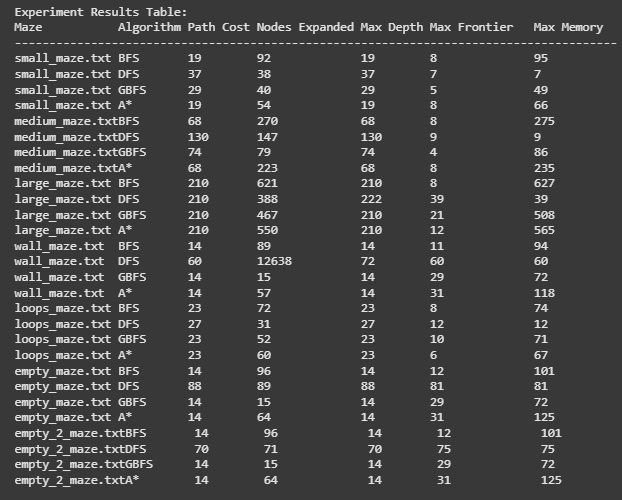

For the open_maze

The code was able to run, but took an extensive amount of time due to the extremely large size of the maze and the time requireed to run each search for the algorithms.


Google Collab does not play nice with it, and as a result took over 3 hours to run.

#This is also what resulted in this assignement being submitted late

Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)).

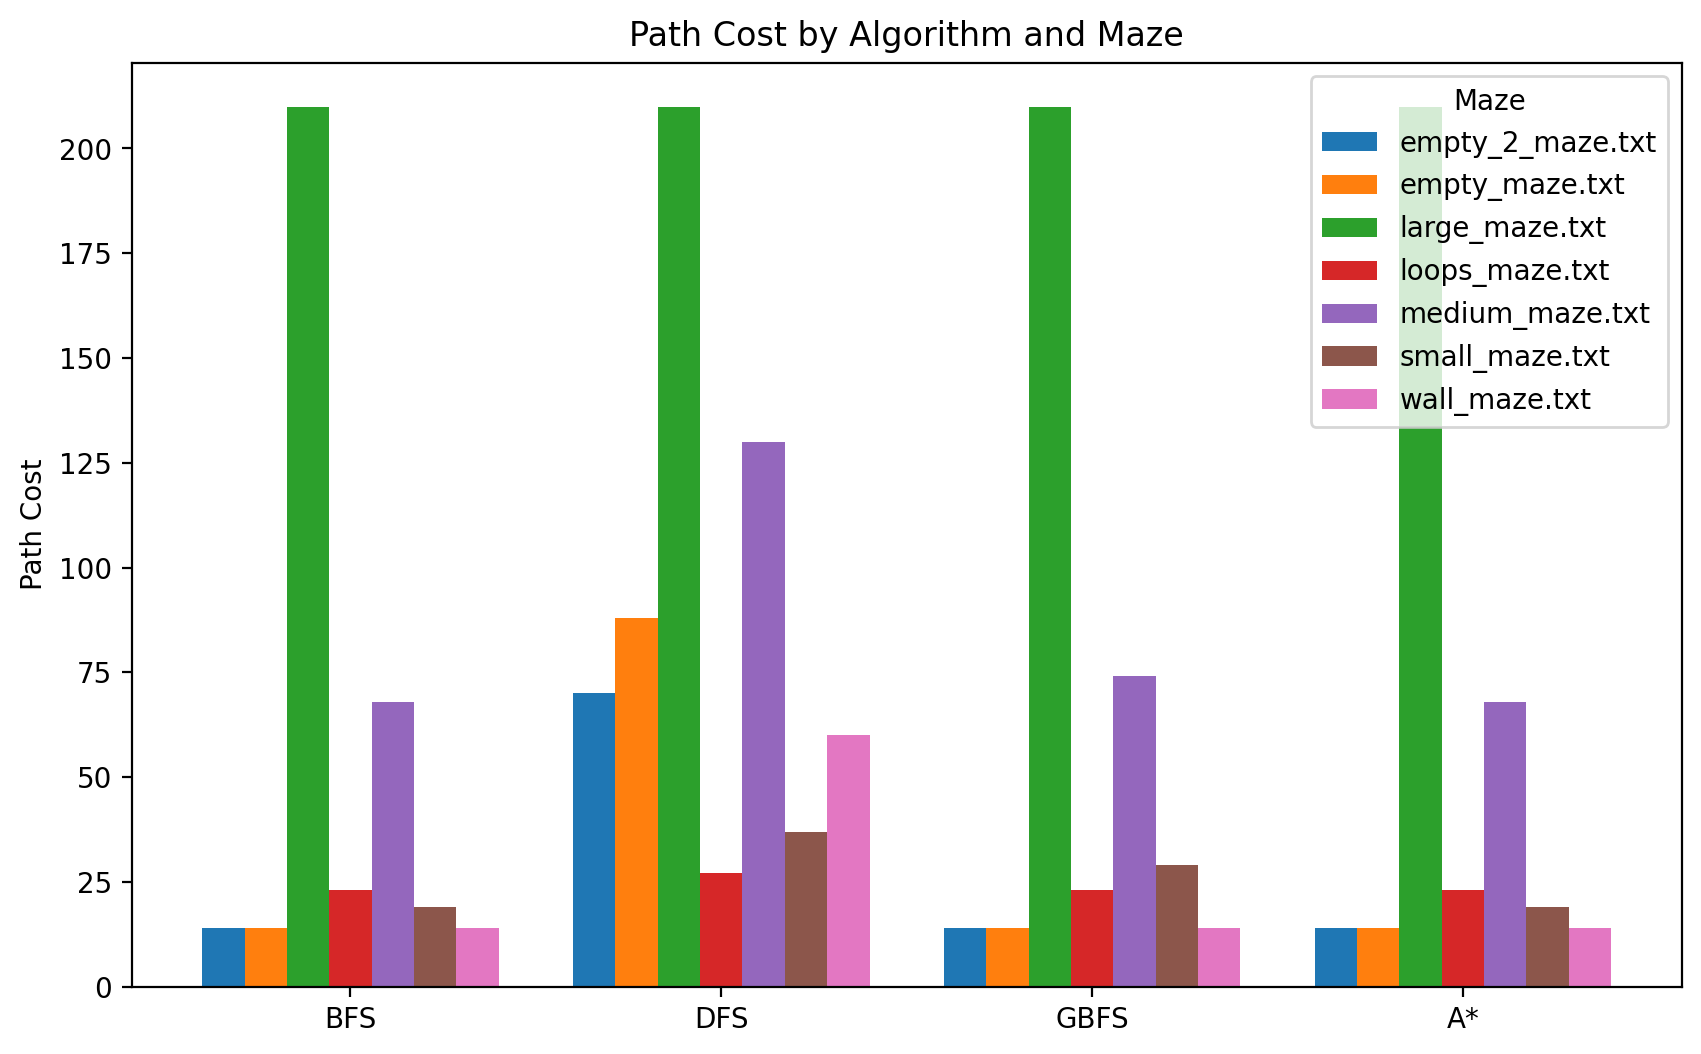

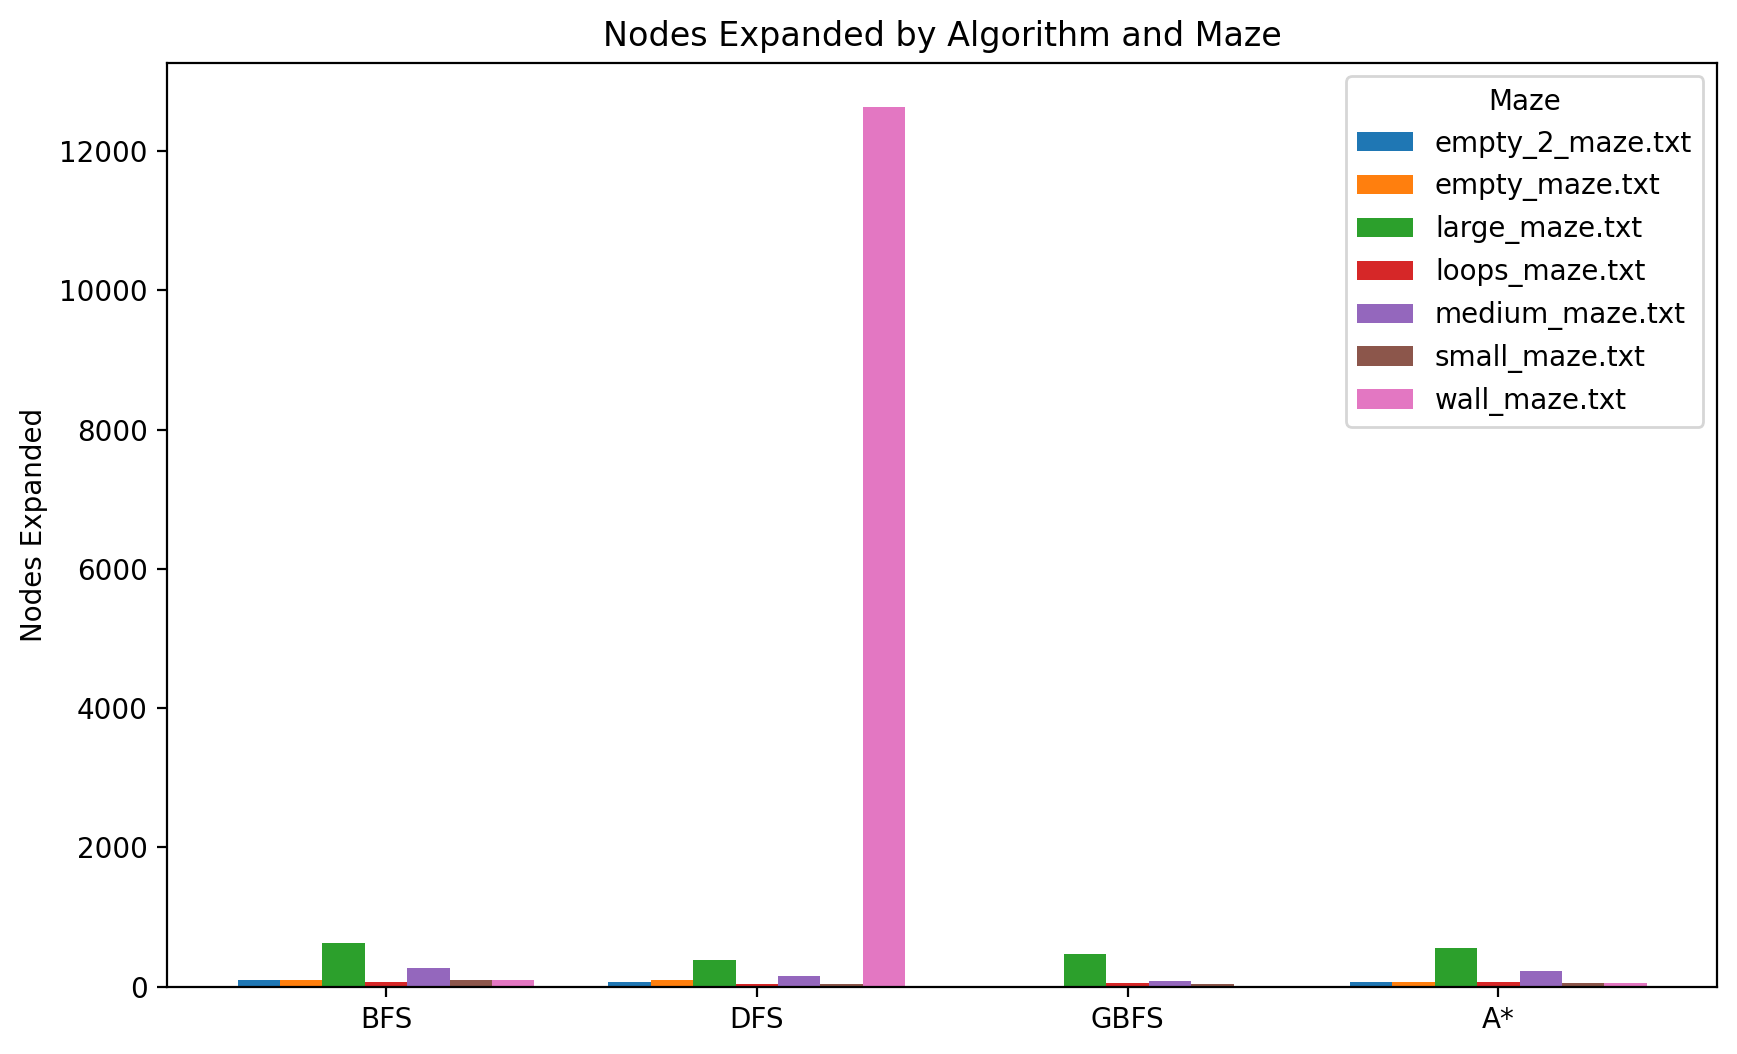

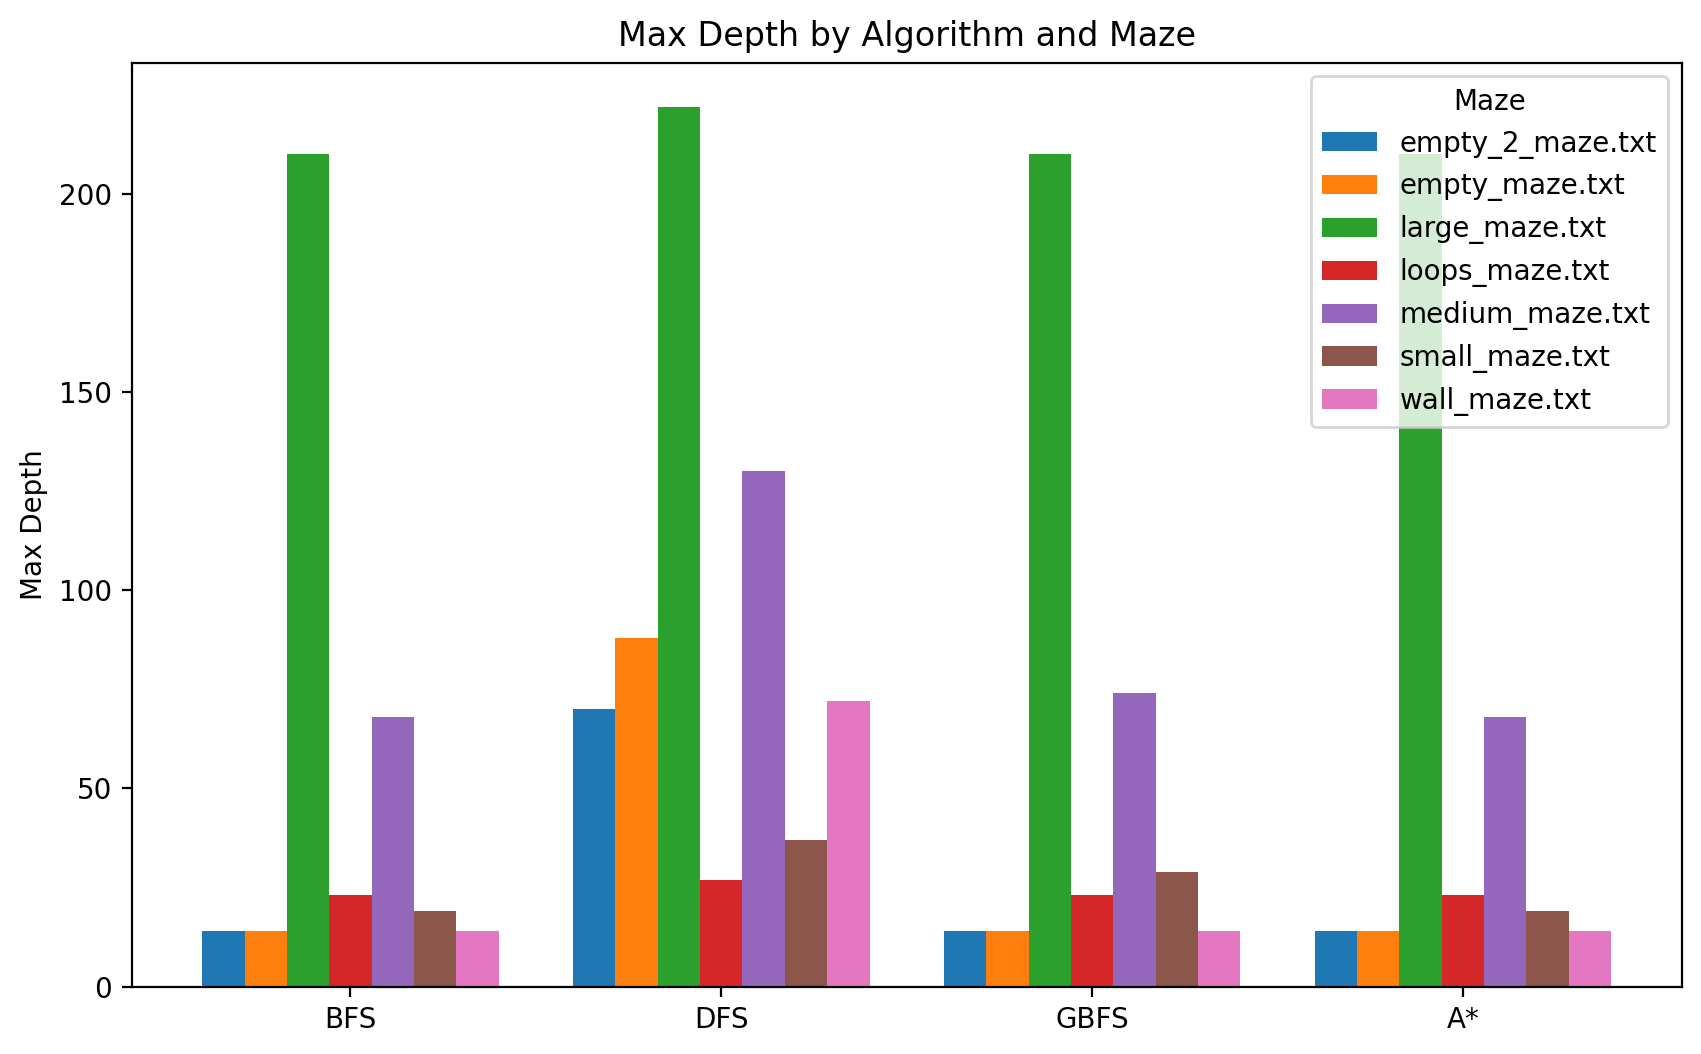

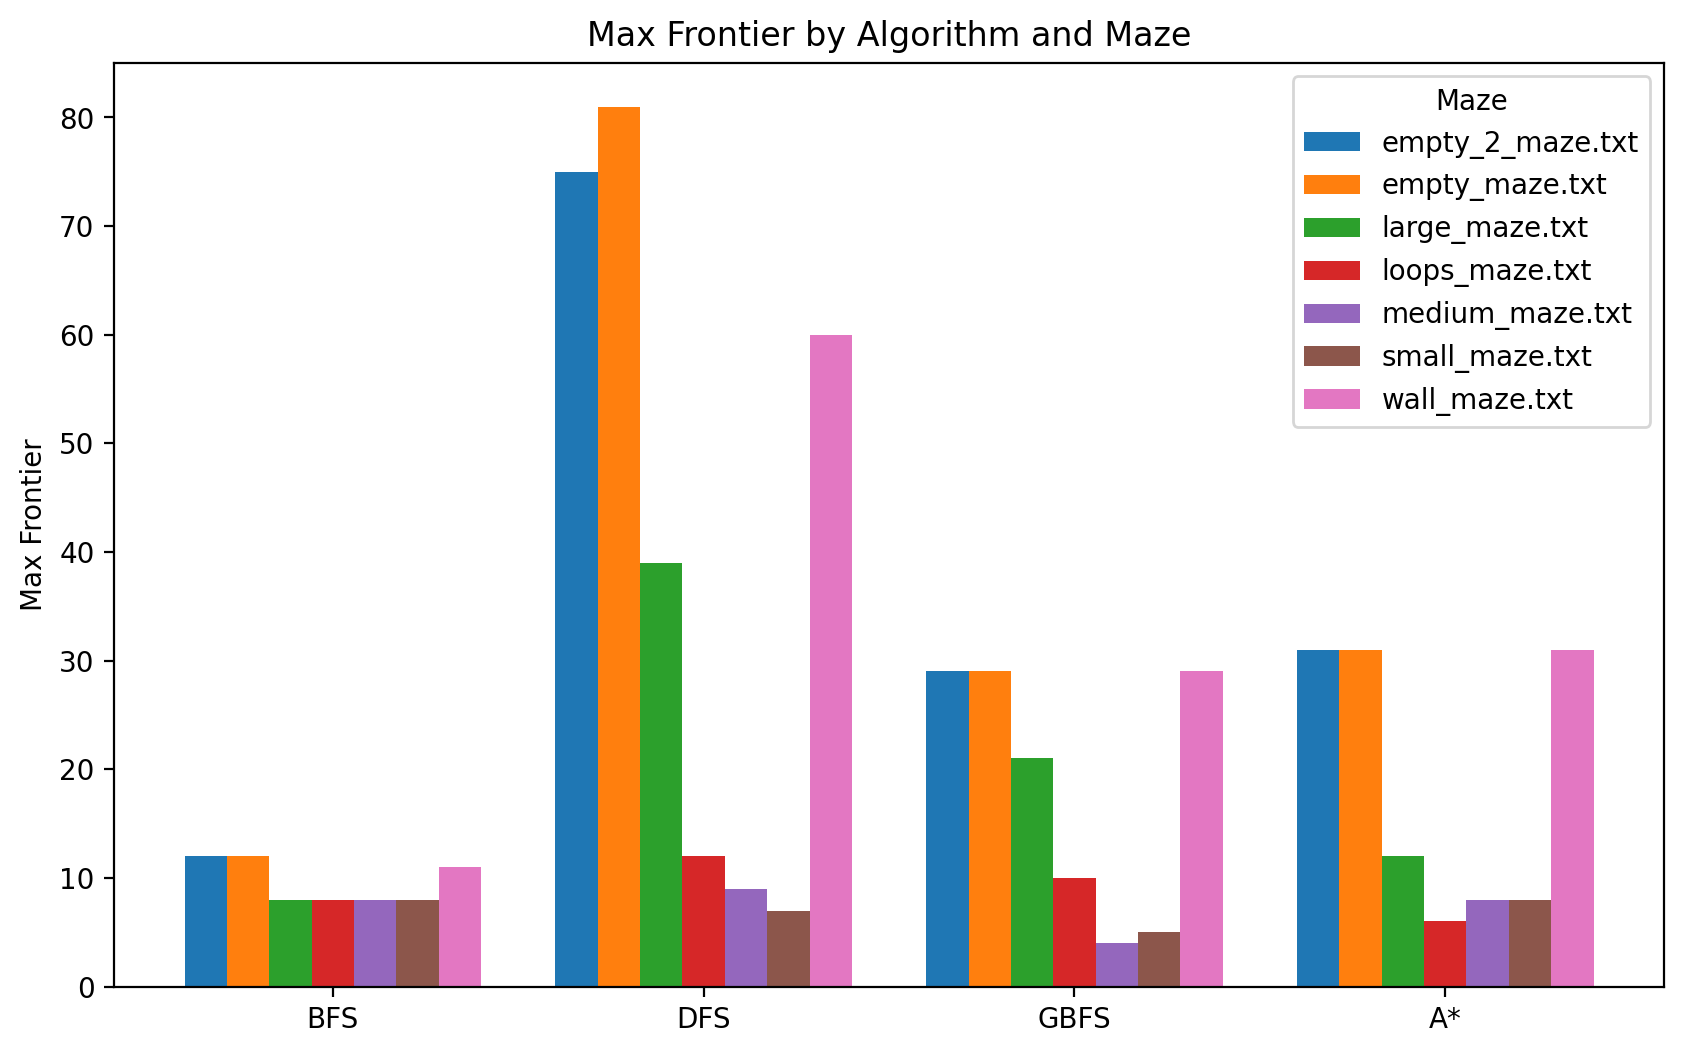

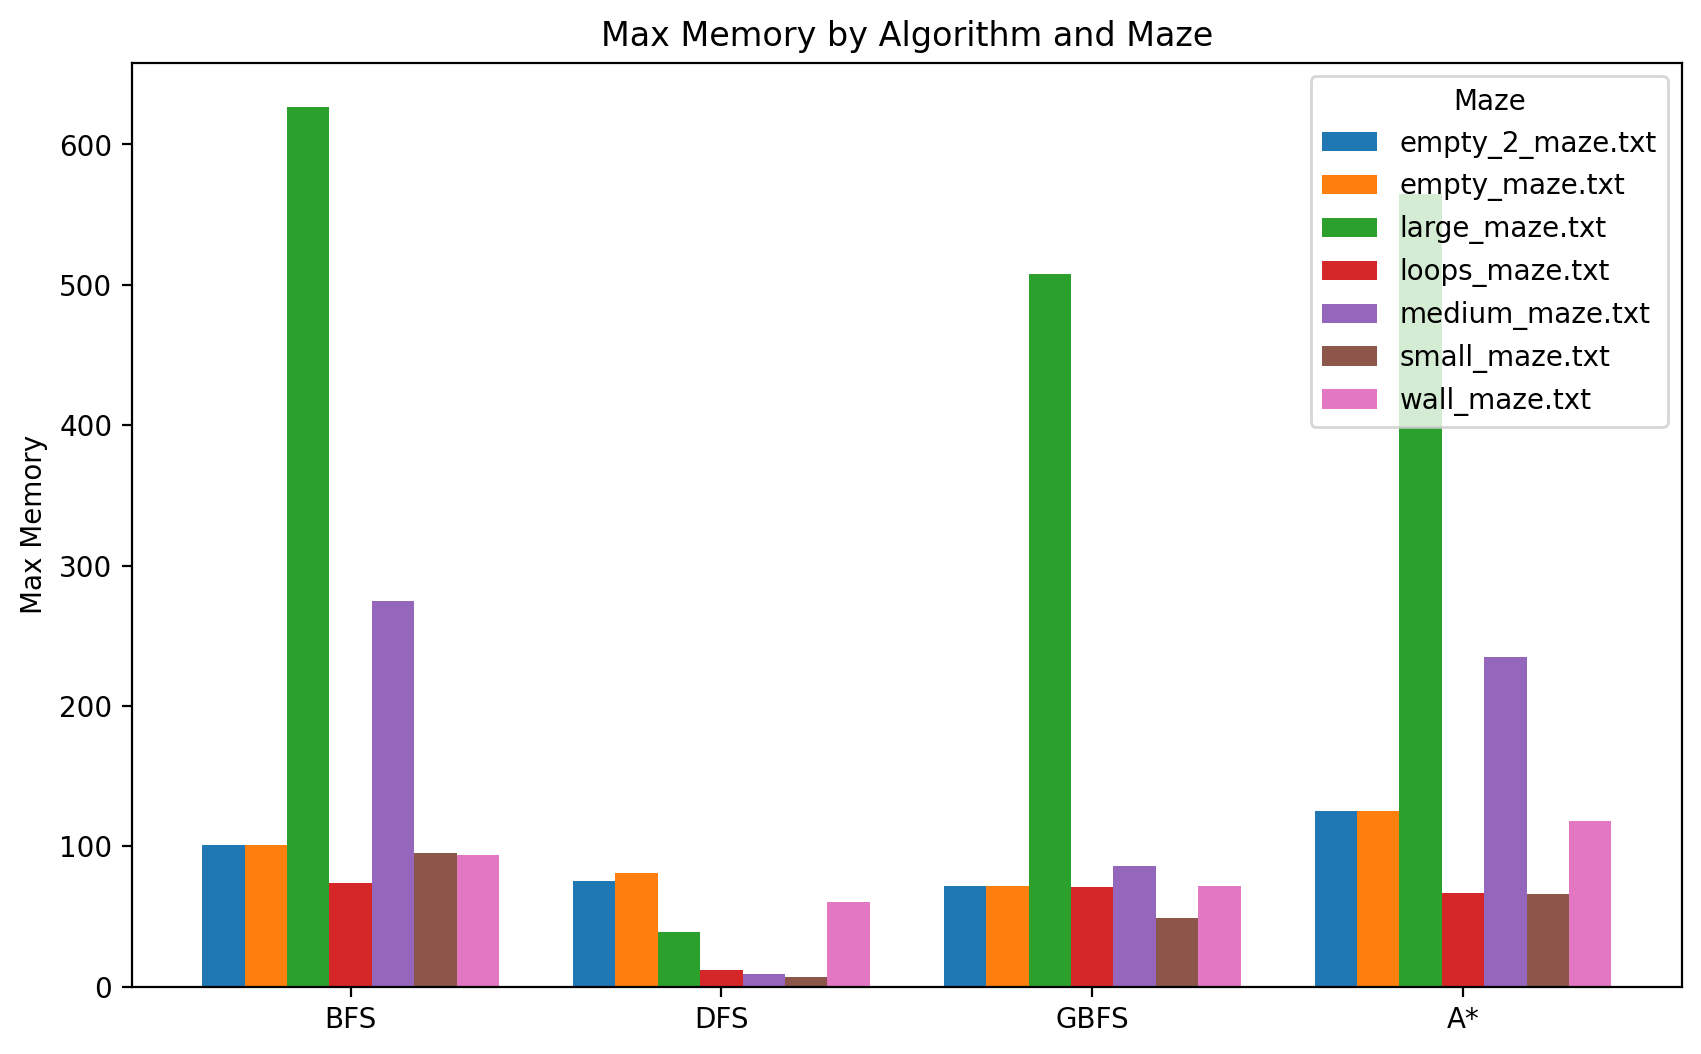

In [12]:
metrics = ["Path Cost", "Nodes Expanded", "Max Depth", "Max Frontier", "Max Memory"]

maze_names = sorted(list(set(r["Maze"] for r in results)))
algo_names = list(algorithms.keys())

for metric in metrics:
    data = {maze: [] for maze in maze_names}
    for maze in maze_names:
        for algo in algo_names:
            rec = next((r for r in results if r["Maze"] == maze and r["Algorithm"] == algo), None)
            if rec is None or isinstance(rec[metric], str):
                data[maze].append(0)
            else:
                data[maze].append(rec[metric])

    x = np.arange(len(algo_names))
    num_mazes = len(maze_names)
    group_width = 0.8  # Total width for all bars in a group
    width = group_width / num_mazes  # Individual bar width

    # Compute offsets so that the bars are centered over the tick.
    offsets = np.linspace(-group_width/2 + width/2, group_width/2 - width/2, num_mazes)

    fig, ax = plt.subplots(figsize=(10,6))

    for i, maze in enumerate(maze_names):
        ax.bar(x + offsets[i], data[maze], width, label=maze)

    ax.set_ylabel(metric)
    ax.set_title(f"{metric} by Algorithm and Maze")
    ax.set_xticks(x)
    ax.set_xticklabels(algo_names)
    ax.legend(title="Maze")

    plt.show()

Discuss the most important lessons you have learned from implementing the different search strategies.

#Lesson Learned

The most major lesson learend here is that A* tends to be the most efficient, and most of them having very similar runtimes for the smaller and empty maze.

DFS appears to be more space efficient, hazing the lowest memory but the highest amount of nodes expanded.

#Second Lesson

Implementing Pathfinding in Python is a pain. Having come from C# and C++, and all of the nicities that came from them, it felt strange having to write them so differently.

#Third lesson

Pathfinding, similar to other algorithms, is not a one size fits all system, some are better in certain situatiuons and some are betrter with others, you will need to pick and choose depending on what you need for what, when.

#Biggest Lesson

Different algorithms have different scalability. Bfs and Dfs was relatively fast for the open maze, while A* took 4 hours.

---
Assignment adapted from [Michael Hahsler](https://github.com/mhahsler/CS7320-AI) under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.